In [5]:
import ase
import ase.io
import numpy as np
import sys
import matplotlib.pyplot as plt
import abtem
# %matplotlib ipympl

sys.path.append('../..')
lufeo3 = ase.io.read("../../data/structures/LFO_LS.vasp")

## STEM Walkthrough

In [6]:
abtem.config.set({"device": "cpu", "fft": "fftw"})

Atom('Fe', [3.4815173297196083, 9.003410199405824, 6.030164718600002], index=62)

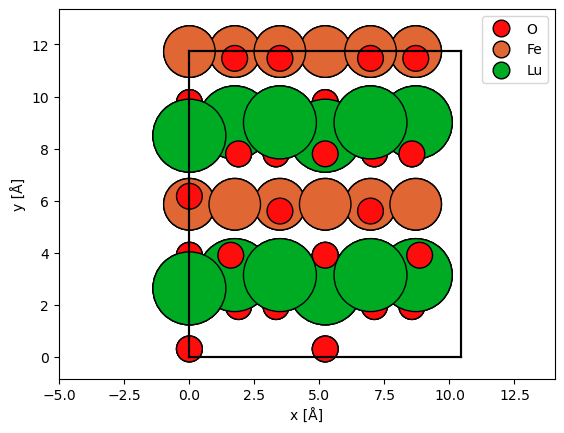

In [102]:
atoms = abtem.orthogonalize_cell(lufeo3)
atoms.rotate(-120, v=[1, 1, 1], rotate_cell=True)  # one call, same result

# anything smaller in magnitude becomes exactly 0 or atoms will be lost at z = 0
tol = 1e-6 
atoms.positions[np.abs(atoms.positions) < tol] = 0.0
atoms.cell[np.abs(atoms.cell) < tol] = 0.0

# Optional: Save the atoms object as a VASP file for later use
# ase.io.write("output.vasp", atoms)


atoms *= (3, 1, 1)
abtem.show_atoms(atoms, plane="xy", legend=True, numbering=False, merge=False);
atoms[62].symbol = "Fe"
atoms[62]


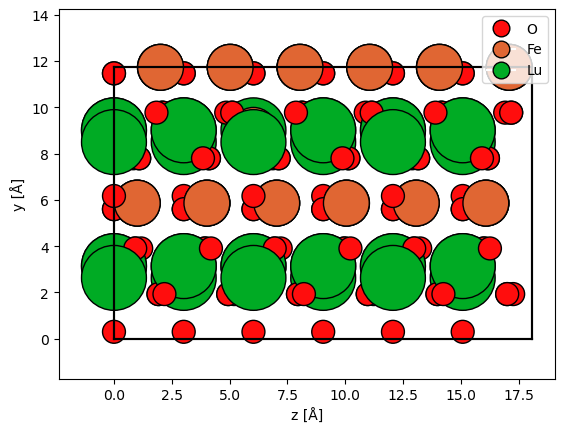

In [103]:
abtem.show_atoms(atoms, 'zy', legend=True, numbering=False, merge=False);

In [104]:
potential = abtem.Potential(atoms, sampling=0.05, plane='xy')

In [ ]:
probe = abtem.Probe(energy=100e3, semiangle_cutoff=32, Cs=0, defocus="scherzer") #Cs in Å
# probe = abtem.Probe(energy=100e3, Cs=10e4, defocus="scherzer")
# probe.semiangle_cutoff = probe.ctf.crossover_angle
probe.grid.match(potential)

print(f"defocus = {probe.aberrations.defocus} Å")
print(f"FWHM = {probe.profiles().width().compute()} Å")

defocus = 0.0 Å
FWHM = 0.7460393905639648 Å


[########################################] | 100% Completed | 105.86 ms
[########################################] | 100% Completed | 105.58 ms


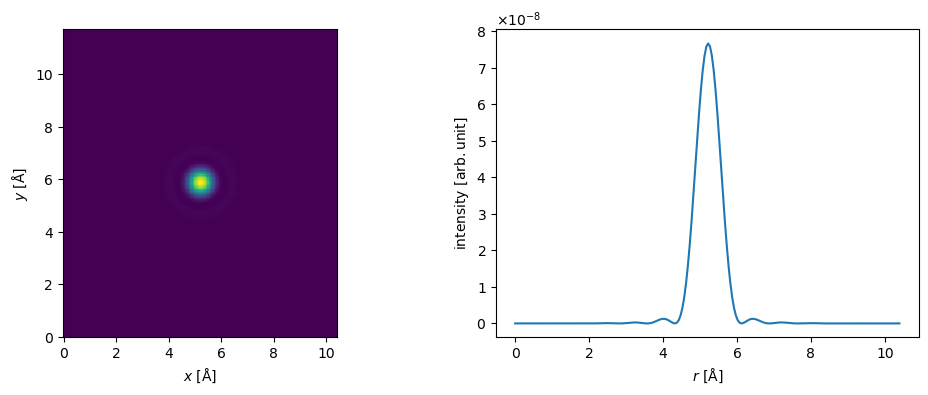

In [106]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
probe.show(ax=ax1)
probe.profiles().show(ax=ax2);

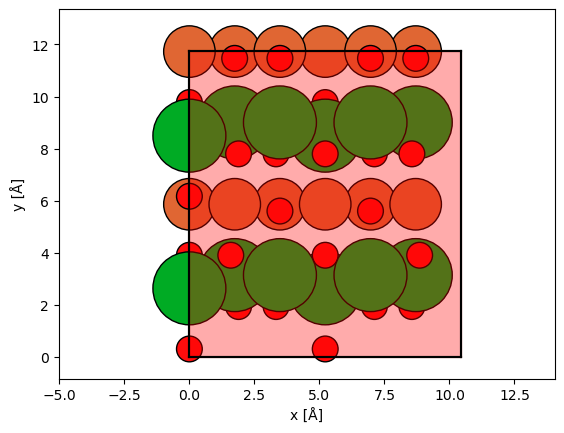

In [107]:
grid_scan = abtem.GridScan(
    start=(0, 0),
    end=(1, 1),
    sampling=probe.aperture.nyquist_sampling,
    fractional=True,
    potential=potential,
)

fig, ax = abtem.show_atoms(atoms, plane="xy")
grid_scan.add_to_plot(ax)

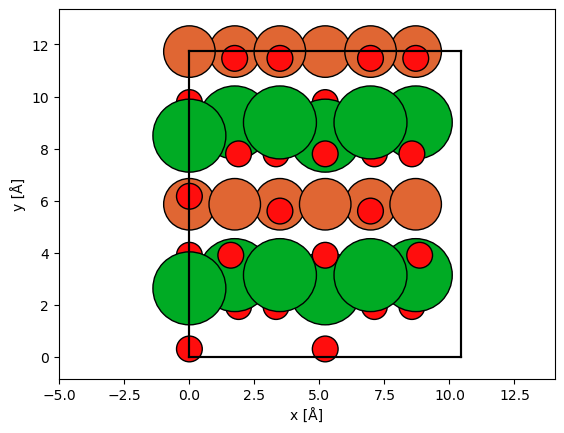

In [108]:
fig, ax = abtem.show_atoms(atoms, plane="xy")

In [109]:
detector = abtem.FlexibleAnnularDetector()

In [110]:
flexible_measurement = probe.scan(potential, scan=grid_scan, detectors=detector)

flexible_measurement.compute()

[########################################] | 100% Completed | 7.78 sms


In [111]:
bf_measurement = flexible_measurement.integrate_radial(0, probe.semiangle_cutoff)
maadf_measurement = flexible_measurement.integrate_radial(50, 150)
haadf_measurement = flexible_measurement.integrate_radial(90, 200)

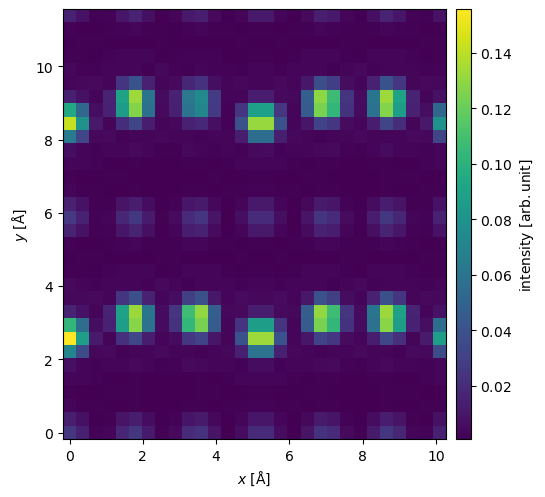

In [112]:
haadf_measurement.show(
    explode=True,
    figsize=(14, 5),
    cbar=True,
);

In [113]:
interpolated_measurements = haadf_measurement.interpolate(0.05)
filtered_measurements = interpolated_measurements.gaussian_filter(0.3)

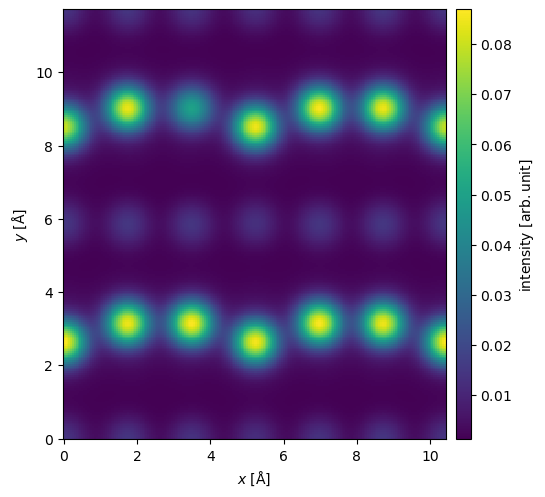

In [99]:
filtered_measurements.show(
    explode=True,
    figsize=(14, 5),
    cbar=True,
);

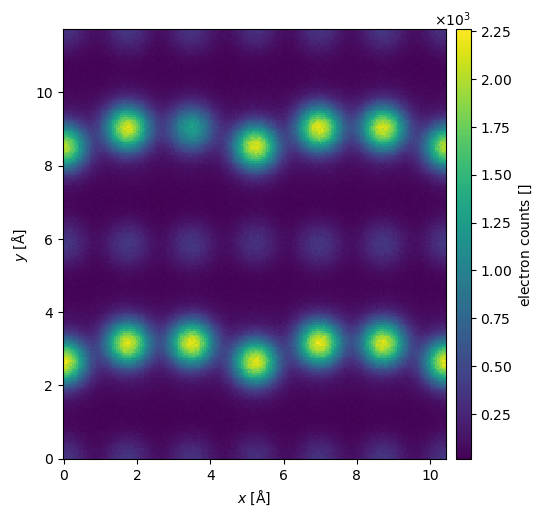

In [100]:
noisy_measurements = filtered_measurements.poisson_noise(dose_per_area=1e7)

noisy_measurements.show(
    explode=True,
    figsize=(14, 5),
    cbar=True,
);

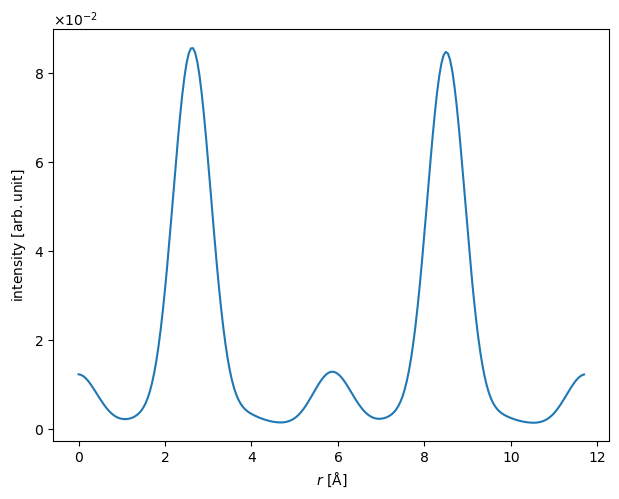

In [101]:
line_profile = filtered_measurements.interpolate_line(
    start=(1 / 2, 0), end=(1 / 2, 1), fractional=True
)

line_profile.show();

In [117]:
import hyperspy.api as hs
roi = hs.load(noisy_measurements.array)

ValueError: The filenames parameter must be a list, tuple, string or None, not <class 'numpy.ndarray'>